In [139]:
!ls /mnt/processed/private/msds2020cpt12/

articles_processed		 lance		       network_iter6.zip
articles_processed_weekly	 load_to_db.py	       network_iter7
articles_processed_weekly_iter2  load_to_db.txt        news.db
articles_processed.zip		 network_iter1.zip     nlp_project
camille				 network_iter2.zip     Sample.ipynb
capstone_repo			 network_iter3	       TM_Attempts_Iter6.ipynb
criselle			 network_iter3.zip     tokens
datasets			 network_iter4	       top20kw.zip
gilbert				 network_iter4_backup  weekly_iter_old7
gilbert_files			 network_iter5
gsa_project			 network_iter6


In [2]:
import glob
import os
import json
import datetime

import sqlite3
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

from collections import Counter, defaultdict

plt.style.use('https://gist.githubusercontent.com/lpsy/'
              '958c8b7a8fcd9c860b5f19ad6c84d054/raw/cpt12.mplstyle')

import sys
sys.path.append(os.path.join(sys.path[0],'capstone_repo','news_processing','helper'))
sys.path.append(os.path.join(sys.path[0],'capstone_repo','news_processing'))
# sys.path.append(os.path.join(sys.path[0],'capstone_repo'))
import utils
from itertools import chain
from operator import itemgetter

from tqdm.autonotebook import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import networkx as nx
import community
from operator import itemgetter

# from tqdm import tqdm
ARTICLES_DIR = '/mnt/processed/private/msds2020cpt12/articles_processed'
TOKENS_DIR = '/mnt/processed/private/msds2020cpt12/network_iter6/01_tokens_combined'
conn = sqlite3.connect(os.path.join(ARTICLES_DIR, 'articles_processed.db'))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
def get_tokens(year, qtr, keyword):
    """Returns a dictionary of {doc_id:tokens}"""
    month_list = np.arange(1,13).reshape(4, 3)[qtr-1]
    all_tokens = {}
    for month in month_list:
        month = f'{int(month):02}'
        glob_str = os.path.join(TOKENS_DIR, str(year), f'{year}{month}*')
        file_list = glob.glob(glob_str)
        assert len(file_list) == 1
        tokens = utils.read_json(file_list[0])
        relevant_docs = [id_ for id_, token in tokens.items() if keyword in token]
#         tokens = dict(filter(lambda x: x[0] in relevant_docs, tokens.items()))
#         all_tokens.update(tokens)
    return relevant_docs

def get_articles(communities):
    """return articles from a given set of doc_ids"""
    articles = defaultdict(list)
    for c, relevant_docs in tqdm(communities.items()):
        if len(relevant_docs) > 1:
            query = f"""SELECT title, date_published
                        FROM articles_processed
                        WHERE document_id IN {tuple(relevant_docs)}"""
            articles[c] = list(conn.execute(query))
        else:
#             pass
            ids = relevant_docs[0]
            query = f"""SELECT title, date_published
                        FROM articles_processed
                        WHERE document_id = '{ids}'"""
            articles[c] = list(conn.execute(query))            
    return articles

In [161]:
df_leni = pd.read_sql(
    '''
            SELECT 
                "LENI" as candidate, 
                title,
                date_published
            FROM articles_processed 
            WHERE UPPER(content) LIKE "% LENI ROBREDO%"
            AND CAST(SUBSTR(date_published, -4) AS INT) BETWEEN 2014 AND 2016 
''', conn)

In [167]:
df_bbm= pd.read_sql(
    '''
            SELECT 
                "BBM" as candidate, 
                title,
                date_published
            FROM articles_processed 
            WHERE UPPER(content) LIKE "% BONG%BONG %"
            AND CAST(SUBSTR(date_published, -4) AS INT) BETWEEN 2014 AND 2016
''', conn)

In [163]:
df_leni

candidate                                              title  \
0         LENI                 No bribe-taker when no bribe-giver   
1         LENI  Koronadal gears for Charter Day anniversary, N...   
2         LENI           Aquino ally: Binay's loss is Roxas' gain   
3         LENI            Binay lead in presidential survey drops   
4         LENI                    Roxas downplays improved rating   
...        ...                                                ...   
3520      LENI  Philippine Congress starts counting presidenti...   
3521      LENI  Duterte wins Philippine presidency in official...   
3522      LENI  Philippine Congress proclaims next president, ...   
3523      LENI                       BC-AS--Asian News Digest, AS   
3524      LENI  Latest News\nMarcos to get hero's burial: Duterte   

         date_published  
0     28 September 2014  
1     29 September 2014  
2     30 September 2014  
3     29 September 2014  
4     30 September 2014  
...                 ...  
3520        25 May 2016  
3521        27 May 2016  
3522        30 May 2016  
3523        30 May 2016  
3524        25 May 2016  

[3525 rows x 3 columns]

In [170]:
df = df_leni.append(df_bbm)
df = df.set_index(pd.to_datetime(df.date_published))

In [187]:
df = df[df.index < '2016-05-15'].copy()

In [190]:
df_cumsum = df.groupby('candidate').title.resample('W').count().unstack().T.cumsum()

In [194]:
line = df_cumsum[df_cumsum.BBM < df_cumsum.LENI].index[0]

In [253]:
(df.groupby('candidate')
 .get_group('LENI')
 .resample('W')
 .title.count()
 .sort_values(ascending=False)).head(10)

date_published
2016-05-15    258
2016-04-17    138
2016-05-08    126
2016-05-01    123
2015-10-11     97
2016-04-24     90
2016-02-14     83
2015-10-18     80
2016-03-20     68
2016-03-13     56
Name: title, dtype: int64

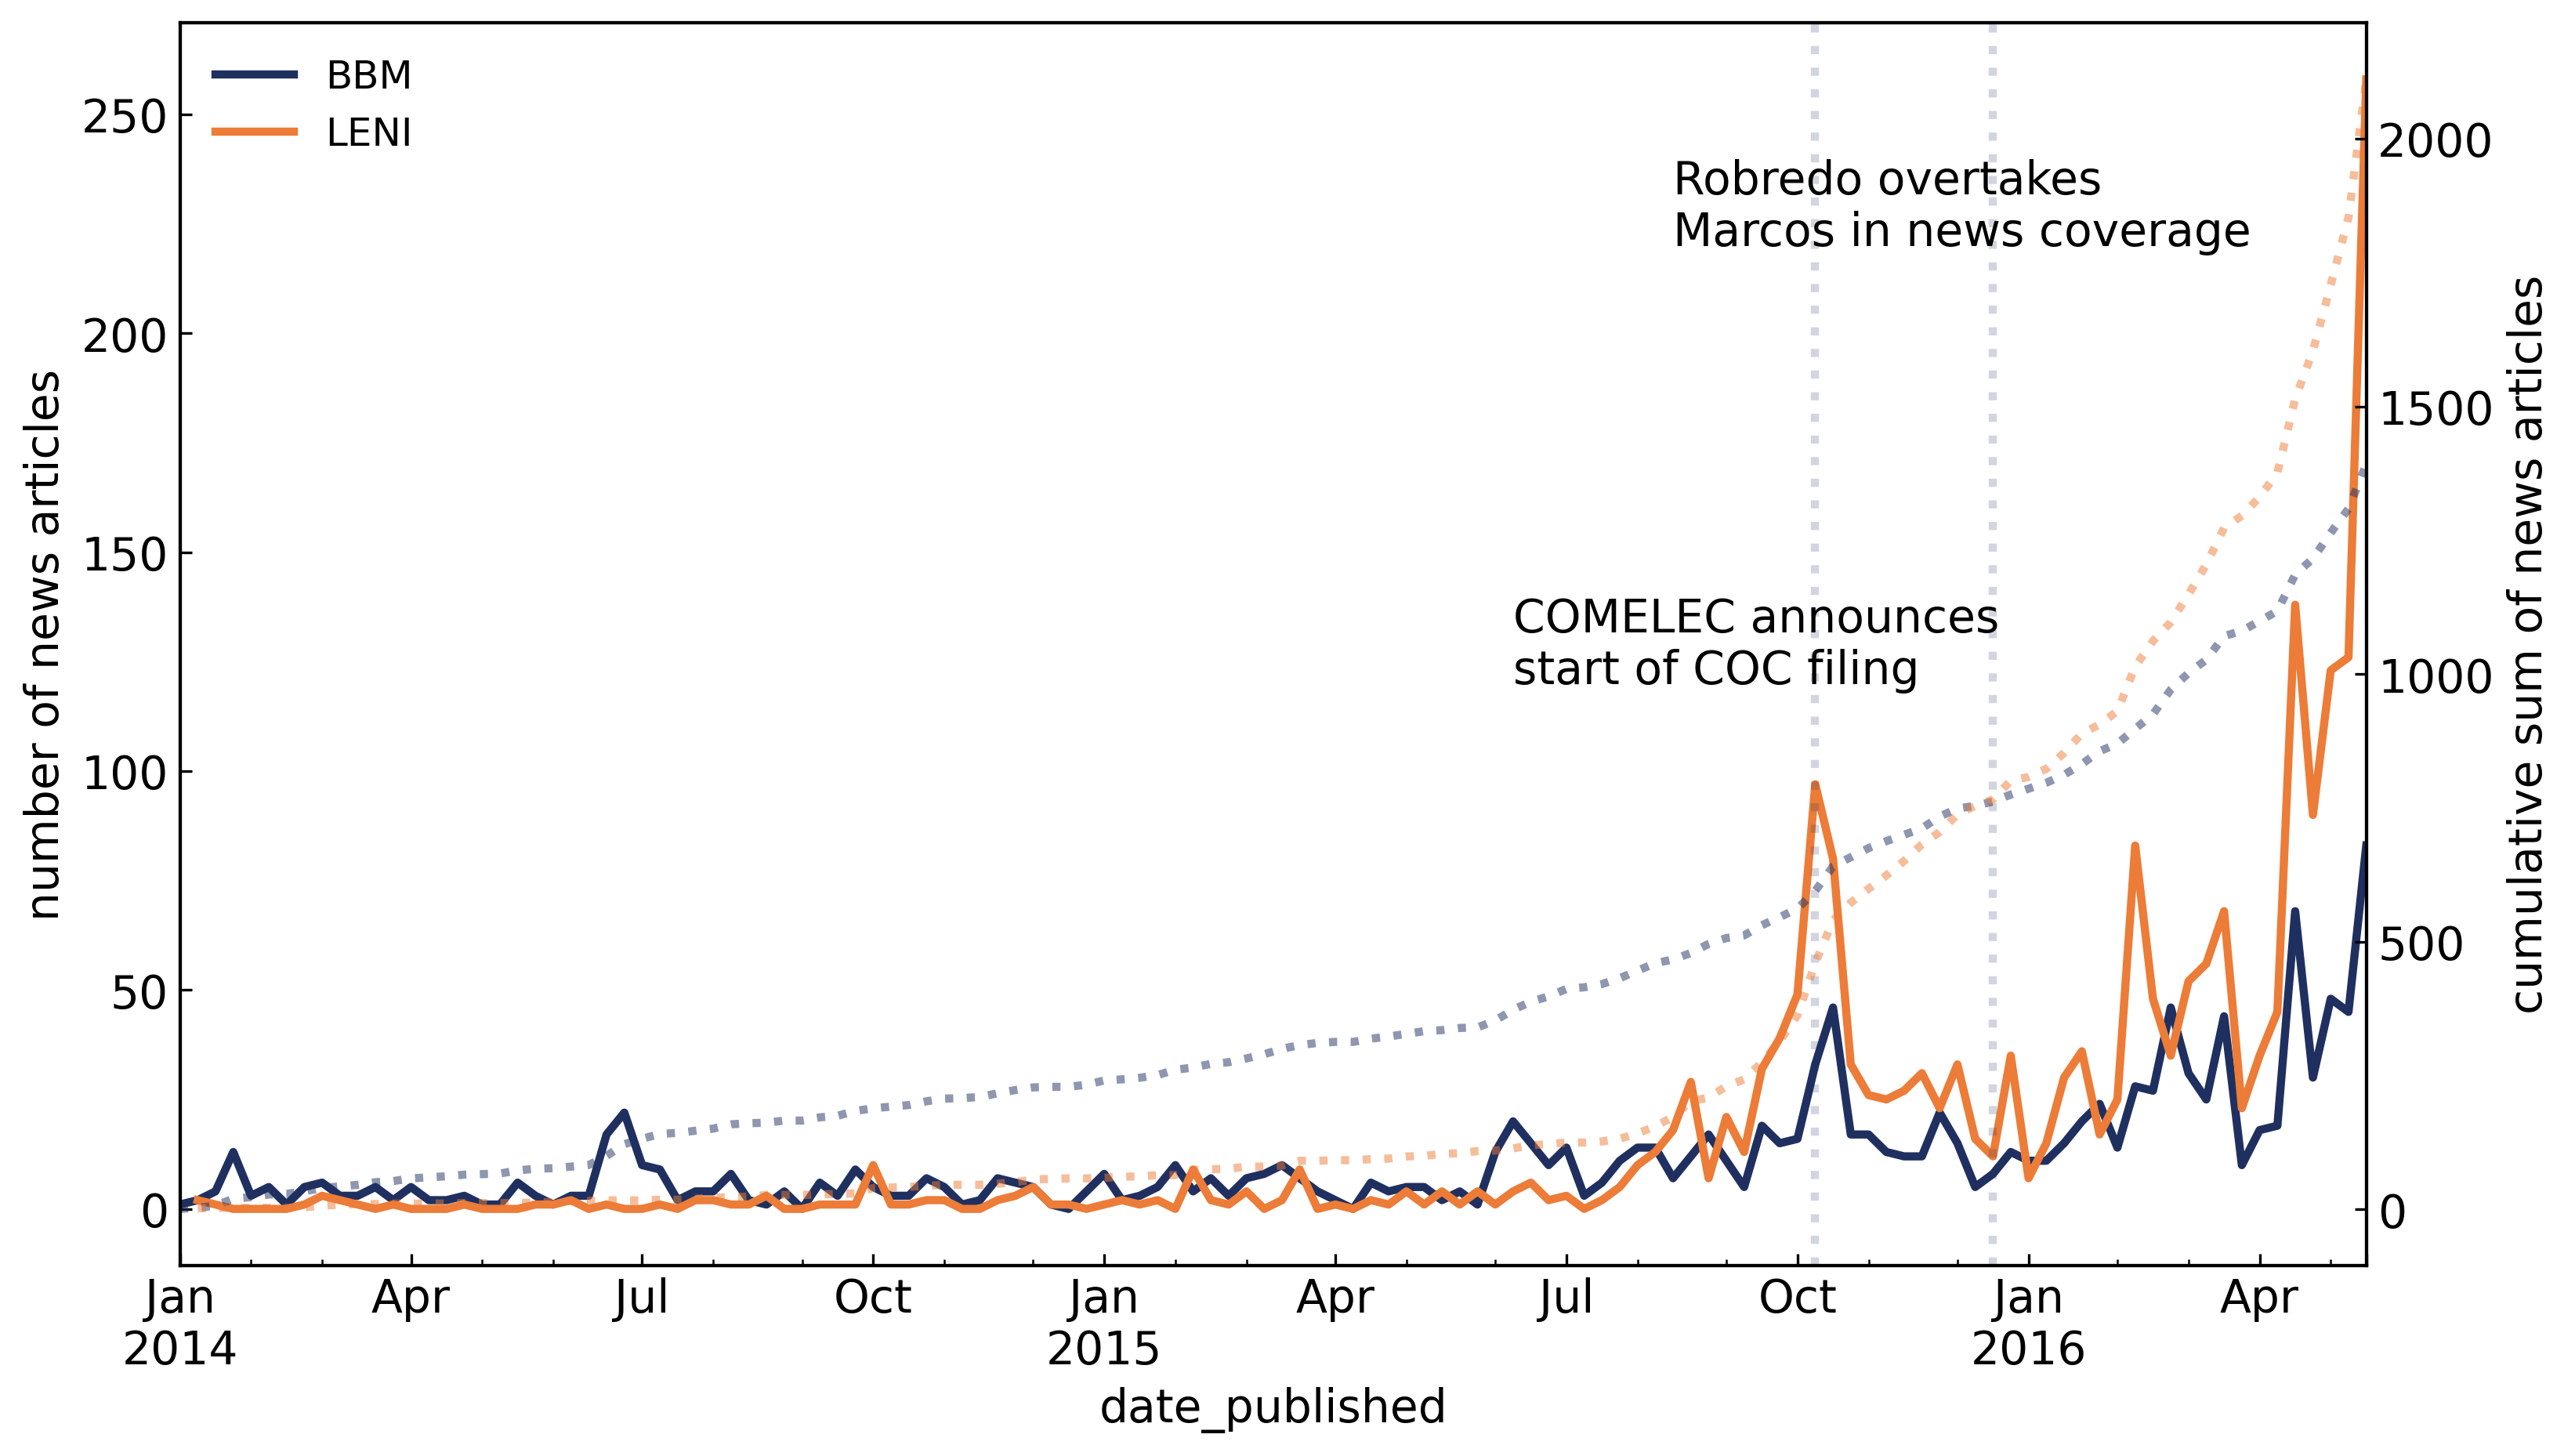

In [273]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
df.groupby('candidate').title.resample('W').count().unstack().T.plot(ax=ax)
ax.axvline(line, linestyle='dotted', alpha=0.2)
ax.axvline('2015-10-11', linestyle='dotted', alpha = 0.2)
df_cumsum.plot(ax=ax2, alpha=0.5, linestyle='dotted', legend=None)
ax.set_ylabel('number of news articles')
ax.legend(loc='upper left')
ax2.set_ylabel('cumulative sum of news articles')
ax.annotate('COMELEC announces \nstart of COC filing', xy=('2015-06-11', 120))
ax.annotate('Robredo overtakes\nMarcos in news coverage', xy=('2015-08-11', 220));

In [256]:
df[df.index == '2015-10-11']

candidate                                              title  \
date_published                                                                
2015-10-11          LENI  Escudero tops Pulse VP poll; Marcos 2nd in 5-w...   
2015-10-11          LENI                                      Marcos for VP   
2015-10-11          LENI  Business News\nFilipinos wary of losing gains ...   
2015-10-11          LENI                    Filing of COCs starts on Monday   
2015-10-11           BBM  Escudero tops Pulse VP poll; Marcos 2nd in 5-w...   
2015-10-11           BBM  With VP bid, dictator's son launches Palace co...   
2015-10-11           BBM                                      Marcos for VP   
2015-10-11           BBM  Latest News\nIN PHOTOS: Marcos formally announ...   
2015-10-11           BBM       Sports\nCaidic stars in benefit game for Lim   
2015-10-11           BBM   Basketball\nCaidic stars in benefit game for Lim   
2015-10-11           BBM  'I will lead a revolution:' Erap, Enrile lead ...   

                 date_published  
date_published                   
2015-10-11      11 October 2015  
2015-10-11      11 October 2015  
2015-10-11      11 October 2015  
2015-10-11      11 October 2015  
2015-10-11      11 October 2015  
2015-10-11      11 October 2015  
2015-10-11      11 October 2015  
2015-10-11      11 October 2015  
2015-10-11      11 October 2015  
2015-10-11      11 October 2015  
2015-10-11      11 October 2015

In [269]:
df[df.index >= line].sort_index()

candidate                                              title  \
date_published                                                                
2015-12-20          LENI                  Poe ally confident of DQ reversal   
2015-12-20           BBM                  Duterte-Marcos is the new 'AlDuB'   
2015-12-20          LENI  National\n'Pantawid' program draws more suppor...   
2015-12-21          LENI  Robredo visits typhoon-hit areas in Sorsogon, ...   
2015-12-21          LENI              Life & Leisure\nHer one yuletide wish   
...                  ...                                                ...   
2016-05-14          LENI                Investigate the Novotel controversy   
2016-05-14          LENI               Marcos leads overseas absentee votes   
2016-05-14          LENI                                 ‘Audit system now’   
2016-05-14          LENI      The real work begins: a look at AmBisyon 2040   
2016-05-14          LENI                The political future of 2016 losers   

                  date_published  
date_published                    
2015-12-20      20 December 2015  
2015-12-20      20 December 2015  
2015-12-20      20 December 2015  
2015-12-21      21 December 2015  
2015-12-21      21 December 2015  
...                          ...  
2016-05-14           14 May 2016  
2016-05-14           14 May 2016  
2016-05-14           14 May 2016  
2016-05-14           14 May 2016  
2016-05-14           14 May 2016  

[1978 rows x 3 columns]

In [272]:
# df[df.title.str.contains('typhoon')]

candidate                                              title  \
date_published                                                                
2015-10-22          LENI  Daang Matuwid's Mar-Leni distribute food packs...   
2015-10-21          LENI  DSWD head denies accusation of campaigning for...   
2015-10-21          LENI  Comelec says: Aspiring candidates don't violat...   
2015-12-21          LENI  Robredo visits typhoon-hit areas in Sorsogon, ...   
2014-11-08           BBM              Philippines marks typhoon anniversary   

                  date_published  
date_published                    
2015-10-22       22 October 2015  
2015-10-21       21 October 2015  
2015-10-21       21 October 2015  
2015-12-21      21 December 2015  
2014-11-08       8 November 2014

In [276]:
df.drop(columns='date_published').to_csv('articles.csv')

In [282]:
df[df.index > '2014-06-01'].query('candidate=="BBM"').sort_index().head(10)

candidate                                              title  \
date_published                                                                
2014-06-05           BBM             Sports News\nWorld Slasher semis today   
2014-06-06           BBM       New treatments for flatter abs, tighter skin   
2014-06-08           BBM             Sports News\nSlashers Cup finals today   
2014-06-10           BBM                              Wishbone—or backbone?   
2014-06-11           BBM     ‘Revilla’s speech for supporters, not critics’   
2014-06-11           BBM                            AD LIB P-Noy's trophies   
2014-06-16           BBM  Business Agenda\nThe 'talented' Senator Bong R...   
2014-06-16           BBM                                Adulterated victory   
2014-06-16           BBM  De Lima: No legal bar yet for Revilla's 2016 p...   
2014-06-17           BBM  Party list solons push separate detention cell...   

               date_published  
date_published                 
2014-06-05        5 June 2014  
2014-06-06        6 June 2014  
2014-06-08        8 June 2014  
2014-06-10       10 June 2014  
2014-06-11       11 June 2014  
2014-06-11       11 June 2014  
2014-06-16       16 June 2014  
2014-06-16       16 June 2014  
2014-06-16       16 June 2014  
2014-06-17       17 June 2014